# Carga de datos

In [1]:
import os
import pandas as pd

def cargar_csv(nombre_archivo):
    """
    Carga un archivo CSV desde la ruta 'Resultados/Archivos_csv/Datos' en un DataFrame de pandas.

    Parámetros
    ----------
    nombre_archivo : str
        Nombre del archivo CSV a cargar.

    Retorna
    -------
    pd.DataFrame
        DataFrame con los datos cargados del archivo CSV.
    """
    # Construir la ruta completa
    ruta_archivo = os.path.join("..","Resultados", "Archivos_csv", "Datos", nombre_archivo)
    
    # Leer el CSV
    df = pd.read_csv(ruta_archivo, encoding="utf-8")
    print(f"Archivo '{ruta_archivo}' cargado correctamente.")
    
    return df

# Significancia de las variables en cada modelo

In [2]:
import sys
import os

# Agrega la carpeta 'src' al path de búsqueda
ruta_src = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

if ruta_src not in sys.path:
    sys.path.insert(0, ruta_src)

from Entrenamiento_Modelos import *


## GLM (Binomial negativo)

In [9]:
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
def entrenar_modelo_glm(df, modelo_familia, variables_independientes, variable_dependiente, test_size=0.2,ranking=False, scaler=False):
    df = df.copy()

    transformaciones = {
        'Contaminacion_aire': ['Contaminacion_aire'],
        'Muertes_agua': ['Muertes_agua', 'I(Muertes_agua**2)','I(Muertes_agua**3)'],
        'Exp_plomo': ['Exp_plomo', 'I(Exp_plomo**2)', 'I(Exp_plomo**3)'],
        'Pesticidas': ['Pesticidas','I(Pesticidas**2)', 'I(Pesticidas**3)'],
        'Precipitaciones': ['Precipitaciones','I(Precipitaciones**2)', 'I(Precipitaciones**3)'],
    }

    # Construir partes de fórmula
    partes_formula = []
    for var in variables_independientes:
        partes_formula.extend(transformaciones.get(var, [var]))

    formula = f"{variable_dependiente} ~ " + " + ".join(partes_formula)

    # Dividir en train/test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=42)

    # Crear matrices con patsy
    y_train, X_train = dmatrices(formula, data=df_train, return_type='dataframe')
    y_test, X_test = dmatrices(formula, data=df_test, return_type='dataframe')

        # Alinear índices
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    scaler_model = None
    if scaler:
        scaler_model = StandardScaler()
    
        # Separar columna intercepto
        intercept_train = X_train[['Intercept']]
        intercept_test = X_test[['Intercept']]
    
        # Escalar solo el resto
        X_train_scaled = scaler_model.fit_transform(X_train.drop(columns='Intercept'))
        X_test_scaled = scaler_model.transform(X_test.drop(columns='Intercept'))
    
        # Reconstruir DataFrames
        X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns.drop('Intercept'))
        X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns.drop('Intercept'))
    
        # Volver a unir la columna Intercept (sin escalar)
        X_train = pd.concat([intercept_train.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)
        X_test = pd.concat([intercept_test.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)

    

    # Entrenar modelo GLM
    modelo = sm.GLM(y_train, X_train, family=modelo_familia).fit()
    print(modelo.summary())

    # Evaluación
    y_pred = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\nRMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    if ranking:
        resumen = modelo.summary2().tables[1].reset_index().rename(columns={'index': 'Variable'})
        resumen = resumen[['Variable', 'P>|z|']]
        resumen = resumen[resumen['Variable'] != 'Intercept']
        resumen = resumen.sort_values(by='P>|z|', ascending=True).reset_index(drop=True)

        # Convertir p-valores a formato legible sin notación científica
        resumen['P>|z|'] = resumen['P>|z|'].apply(lambda x: f'{x:.5f}')  # Limitar a 5 decimales, o el formato que necesites

        # Mostrar el ranking por pantalla
        print("\nRanking de variables por p-valor (GLM):")
        print(resumen)
        # ✅ Guardar solo variables principales
        variables_interes = [
            "Exp_plomo",
            "Muertes_agua",
            "Contaminacion_aire",
            "Pesticidas",
            "Precipitaciones"
        ]
        resumen_filtrado = resumen[resumen["Variable"].isin(variables_interes)]
        
        # Definir ruta para guardar
        ruta_guardado = os.path.join("..","Resultados", "Importancia_variables","CSV")
        os.makedirs(ruta_guardado, exist_ok=True)  # Crea la carpeta si no existe

        ruta_csv = os.path.join(ruta_guardado, "Ranking_variables_GLM.csv")
        resumen_filtrado.to_csv(ruta_csv, index=False)
        print(f"Archivo guardado en: {ruta_csv}")

        # Gráfico de p-valores
        plt.figure(figsize=(8, max(4, len(resumen) * 0.4)))
        # Asignar un hue ficticio para evitar el mensaje de advertencia
        resumen['hue'] = 'p-valor'
        sns.barplot(data=resumen, y='Variable', x='P>|z|', hue='hue', palette='Blues_r')

        plt.title("Ranking de variables por p-valor (GLM)")
        plt.xlabel("P-valor")
        plt.ylabel("Variable")
        plt.legend()
        plt.tight_layout()
        plt.gca().invert_yaxis()
        plt.show()

        ruta_guardado_img = os.path.join("..", "Resultados", "Importancia_variables", "Gráficos")
        os.makedirs(ruta_guardado_img, exist_ok=True)
        ruta_img = os.path.join(ruta_guardado_img, "Ranking_variables_GLM.png")
        plt.savefig(ruta_img, dpi=300)  # Guardar imagen
        
        plt.show()
        
        print(f"Mapa guardado en: {ruta_guardado_img }")  

    return modelo, scaler_model, transformaciones, formula

Archivo '..\Resultados\Archivos_csv\Datos\Tabla_modelos.csv' cargado correctamente.

Modelo Binomial Negativo:


C:\Users\luism\anaconda3\envs\TFG\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:              Parkinson   No. Observations:                 4331
Model:                            GLM   Df Residuals:                     4317
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22138.
Date:                Fri, 13 Jun 2025   Deviance:                       982.30
Time:                        18:28:07   Pearson chi2:                 1.26e+03
No. Iterations:                    12   Pseudo R-squ. (CS):             0.4358
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

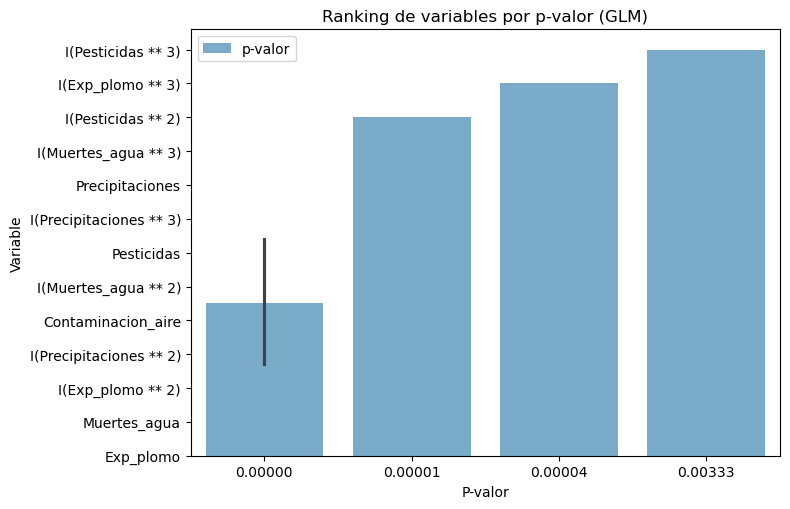

<Figure size 640x480 with 0 Axes>

Mapa guardado en: ..\Resultados\Importancia_variables\Gráficos


In [10]:
import seaborn as sns
# Cargar los datos
df = cargar_csv("Tabla_modelos.csv")

# Definir las variables
variables_independientes = ['Contaminacion_aire', 'Muertes_agua', 'Exp_plomo', 'Pesticidas','Precipitaciones']
variable_dependiente = 'Parkinson'

print("\nModelo Binomial Negativo:")
modelo_GLM=entrenar_modelo_glm(df, sm.families.NegativeBinomial(), variables_independientes, variable_dependiente, ranking = True,scaler=True)

## RF Regressor

In [7]:
# Modelo Random Forest
def entrenar_modelo_rf(df, variables_independientes, variable_dependiente, test_size=0.2,ranking=False):
    """
    Entrena un modelo Random Forest, escala las variables, y calcula la importancia de las variables 
    tanto por feature importance como por permutación.
    
    Parámetros:
    - df: DataFrame con los datos.
    - variables_independientes: lista de nombres de las columnas que se usarán como variables independientes.
    - variable_dependiente: nombre de la columna de la variable dependiente.
    - test_size: proporción del conjunto de test.
    
    Retorna:
    - modelo_global: el modelo entrenado de Random Forest.
    - importancia_df: DataFrame con la importancia de las variables (feature importance).
    - importancia_perm: DataFrame con la importancia por permutación.
    """
    
    # 1. Separar X e y
    X = df[variables_independientes].copy()
    y = df[variable_dependiente].copy()

    # 2. Escalar las variables independientes
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=variables_independientes)

    # 3. Dividir en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)

    # 4. Entrenar el modelo Random Forest
    modelo_global = RandomForestRegressor(
        n_estimators=484,
        max_depth=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features=None,
        random_state=42
    )
    modelo_global.fit(X_train, y_train)

    # 5. Evaluar el modelo
    y_pred = modelo_global.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"\nMAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # 7. Importancia por permutación
    resultado = permutation_importance(modelo_global, X_test, y_test, n_repeats=30, random_state=42)

    importancia_perm = pd.DataFrame({
        'Variable': variables_independientes,
        'Importancia Media': resultado.importances_mean,
        'Desviación': resultado.importances_std
    }).sort_values(by='Importancia Media', ascending=False)

    print("\nImportancia de las variables (Permutación):")
    print(importancia_perm)
    # Guardar en ruta relativa ../Resultados/Archivos_csv/Datos
    ruta_destino = os.path.join("..","Resultados", "Importancia_variables","CSV")
    os.makedirs(ruta_destino, exist_ok=True)
    ruta_csv = os.path.join(ruta_destino, "Ranking_variables_RF.csv")
    importancia_perm.to_csv(ruta_csv, index=False)
    print(f"\nArchivo de ranking guardado en: {ruta_csv}")

    if ranking:
        # 8. Gráfico de importancia
        plt.figure(figsize=(8, 4))
        plt.barh(importancia_perm['Variable'], importancia_perm['Importancia Media'], 
                 xerr=importancia_perm['Desviación'])
        plt.xlabel("Importancia (disminución en score)")
        plt.title("Importancia de variables - Permutación (RF)")
        plt.tight_layout()
        plt.gca().invert_yaxis()
        plt.show()
    
    return modelo_global,variables_independientes


MAE: 8.44, RMSE: 17.99

Importancia de las variables (Permutación):
             Variable  Importancia Media  Desviación
2           Exp_plomo           0.647697    0.024155
1        Muertes_agua           0.367034    0.016486
3          Pesticidas           0.329581    0.019469
4     Precipitaciones           0.220515    0.018995
0  Contaminacion_aire           0.063634    0.007638

Archivo de ranking guardado en: ..\Resultados\Importancia_variables\CSV\Ranking_variables_RF.csv


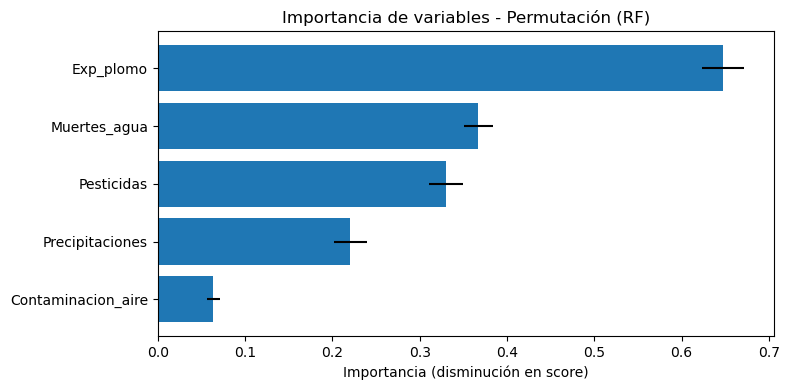

In [8]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
# 1. Cargar los datos


# 2. Definir variables
variables_independientes = ['Contaminacion_aire', 'Muertes_agua', 'Exp_plomo', 'Pesticidas','Precipitaciones']
variable_dependiente = 'Parkinson'

# 3. Llamar a la función
modelo_global,_ = entrenar_modelo_rf(df, variables_independientes, variable_dependiente,0.2,True)

## XG Boosting

In [11]:
def entrenar_modelo_xgboost(df, variables_independientes, variable_dependiente, test_size=0.2,ranking=False):
    df = df.copy()

    # 1. Separar X e y
    X = df[variables_independientes]
    y = df[variable_dependiente]

    # 2. Escalar variables
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=variables_independientes)

    # 3. Dividir en entrenamiento y test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)

    # 4. Definir el modelo
    modelo = xgb.XGBRegressor(
        n_estimators=829,
        learning_rate=0.053,
        max_depth=6,
        min_child_weight=5,
        subsample=0.84,
        colsample_bytree=0.96,
        gamma= 1.2,
        reg_alpha= 0.99,
        reg_lambda= 0.24,
        random_state=42,
        
    )

    # 5. Entrenar el modelo
    modelo.fit(X_train, y_train)

    # 6. Evaluación
    y_pred = modelo.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

    # 8. Importancia por permutación
    resultado = permutation_importance(modelo, X_test, y_test, n_repeats=30, random_state=42)

    importancia_perm = pd.DataFrame({
        'Variable': variables_independientes,
        'Importancia Media': resultado.importances_mean,
        'Desviación': resultado.importances_std
    }).sort_values(by='Importancia Media', ascending=False)

    print("\nImportancia de las variables (Permutación):")
    print(importancia_perm)

    # Guardar en ruta relativa ../Resultados/Archivos_csv/Datos
    ruta_destino = os.path.join("..","Resultados", "Importancia_variables","CSV")
    os.makedirs(ruta_destino, exist_ok=True)
    ruta_csv = os.path.join(ruta_destino, "Ranking_variables_XG.csv")
    importancia_perm.to_csv(ruta_csv, index=False)
    print(f"\nArchivo de ranking guardado en: {ruta_csv}")

    if ranking:
        # 8. Gráfico de importancia
        plt.figure(figsize=(8, 4))
        plt.barh(importancia_perm['Variable'], importancia_perm['Importancia Media'], 
                 xerr=importancia_perm['Desviación'])
        plt.xlabel("Importancia (disminución en score)")
        plt.title("Importancia de variables - Permutación (XGBOOST)")
        plt.tight_layout()
        plt.gca().invert_yaxis()
        plt.show()
    
    return modelo, variables_independientes


Archivo '..\Resultados\Archivos_csv\Datos\Tabla_modelos.csv' cargado correctamente.

MAE: 8.56, RMSE: 15.21, R²: 0.96

Importancia de las variables (Permutación):
             Variable  Importancia Media  Desviación
2           Exp_plomo           0.560616    0.021130
1        Muertes_agua           0.366134    0.016585
3          Pesticidas           0.319859    0.017344
4     Precipitaciones           0.156273    0.010569
0  Contaminacion_aire           0.071014    0.006622

Archivo de ranking guardado en: ..\Resultados\Importancia_variables\CSV\Ranking_variables_XG.csv


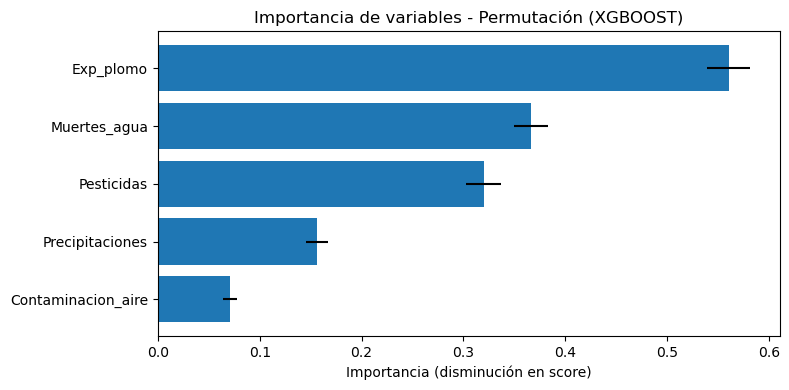

In [14]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Cargar los datos
df = cargar_csv("Tabla_modelos.csv")

# 2. Definir variables
variables_independientes = ['Contaminacion_aire', 'Muertes_agua', 'Exp_plomo', 'Pesticidas','Precipitaciones']
variable_dependiente = 'Parkinson'

# 3. Entrenar modelo global (sin separar por país)
modelo_global, _ = entrenar_modelo_xgboost(df, variables_independientes, variable_dependiente,0.2,True)

## SVR Regressor

In [15]:
def entrenar_modelo_svr(df, variables_independientes, variable_dependiente, test_size=0.2,ranking=False):
    df = df.copy()

    # 1. Separar X e y
    X = df[variables_independientes]
    y = df[variable_dependiente]

    # 2. Escalar variables
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=variables_independientes)

    # 3. Dividir en entrenamiento y test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)

    # 4. Definir el modelo con tus hiperparámetros óptimos
    modelo = SVR(C=1000, epsilon=1, gamma=10, kernel='rbf')

    # 5. Entrenar el modelo
    modelo.fit(X_train, y_train)

    # 6. Evaluación
    y_pred = modelo.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

    # 7. Importancia por permutación
    resultado = permutation_importance(modelo, X_test, y_test, n_repeats=30, random_state=42)

    importancia_perm = pd.DataFrame({
        'Variable': variables_independientes,
        'Importancia Media': resultado.importances_mean,
        'Desviación': resultado.importances_std
    }).sort_values(by='Importancia Media', ascending=False)

    print("\nImportancia de las variables (Permutación - SVR):")
    print(importancia_perm)
    # Guardar en ruta relativa ../Resultados/Archivos_csv/Datos
    ruta_destino = os.path.join("..","Resultados", "Importancia_variables","CSV")
    os.makedirs(ruta_destino, exist_ok=True)
    ruta_csv = os.path.join(ruta_destino, "Ranking_variables_SVR.csv")
    importancia_perm.to_csv(ruta_csv, index=False)
    print(f"\nArchivo de ranking guardado en: {ruta_csv}")

    if ranking:
        # 8. Gráfico de importancia
        plt.figure(figsize=(8, 4))
        plt.barh(importancia_perm['Variable'], importancia_perm['Importancia Media'], 
                 xerr=importancia_perm['Desviación'])
        plt.xlabel("Importancia (disminución en score)")
        plt.title("Importancia de variables - Permutación (SVR)")
        plt.tight_layout()
        plt.gca().invert_yaxis()
        plt.show()

    return modelo, variables_independientes


MAE: 13.45, RMSE: 24.37, R²: 0.91

Importancia de las variables (Permutación - SVR):
             Variable  Importancia Media  Desviación
2           Exp_plomo           0.961939    0.043164
4     Precipitaciones           0.440666    0.033244
3          Pesticidas           0.300031    0.018164
0  Contaminacion_aire           0.294097    0.030073
1        Muertes_agua           0.178634    0.022473

Archivo de ranking guardado en: ..\Resultados\Importancia_variables\CSV\Ranking_variables_SVR.csv


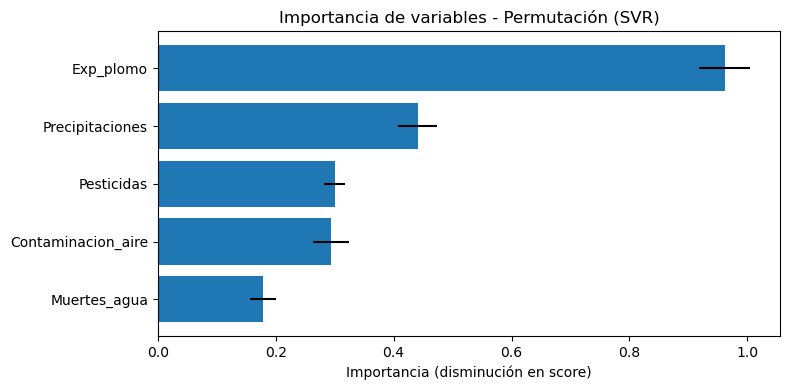

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR

# 2. Definir variables
variables_independientes = ['Contaminacion_aire', 'Muertes_agua', 'Exp_plomo', 'Pesticidas','Precipitaciones']
variable_dependiente = 'Parkinson'

# 3. Entrenar modelo global (sin separar por país)
modelo_global, _ = entrenar_modelo_svr(df, variables_independientes, variable_dependiente,0.2,True)

## KNN Regressor

In [17]:
def entrenar_modelo_knn(df, variables_independientes, variable_dependiente, test_size=0.2, ranking=False):
    df = df.copy()

    # 1. Separar X e y
    X = df[variables_independientes]
    y = df[variable_dependiente]

    # 2. Escalar variables
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=variables_independientes)

    # 3. Dividir en entrenamiento y test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)

    # 4. Definir y entrenar el modelo KNN
    modelo = KNeighborsRegressor(n_neighbors=5, weights='distance', metric='manhattan',algorithm='auto')
    modelo.fit(X_train, y_train)

    # 5. Evaluación
    y_pred = modelo.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

    # 6. Importancia por permutación
    resultado = permutation_importance(modelo, X_test, y_test, n_repeats=30, random_state=42)

    importancia_perm = pd.DataFrame({
        'Variable': variables_independientes,
        'Importancia Media': resultado.importances_mean,
        'Desviación': resultado.importances_std
    }).sort_values(by='Importancia Media', ascending=False)

    print("\nImportancia de las variables (Permutación - KNN):")
    print(importancia_perm)
    # Guardar en ruta relativa ../Resultados/Archivos_csv/Datos
    ruta_destino = os.path.join("..","Resultados", "Importancia_variables","CSV")
    os.makedirs(ruta_destino, exist_ok=True)
    ruta_csv = os.path.join(ruta_destino, "Ranking_variables_KNN.csv")
    importancia_perm.to_csv(ruta_csv, index=False)
    print(f"\nArchivo de ranking guardado en: {ruta_csv}")

    if ranking:
        # 7. Gráfico de importancia
        plt.figure(figsize=(8, 4))
        plt.barh(importancia_perm['Variable'], importancia_perm['Importancia Media'], 
                 xerr=importancia_perm['Desviación'])
        plt.xlabel("Importancia (disminución en score)")
        plt.title("Importancia de variables - Permutación (KNN)")
        plt.tight_layout()
        plt.gca().invert_yaxis()
        plt.show()

    return modelo, variables_independientes


MAE: 11.78, RMSE: 22.70, R²: 0.92

Importancia de las variables (Permutación - KNN):
             Variable  Importancia Media  Desviación
2           Exp_plomo           1.051941    0.047159
4     Precipitaciones           0.396137    0.028157
3          Pesticidas           0.265150    0.022961
0  Contaminacion_aire           0.252814    0.026229
1        Muertes_agua           0.058226    0.012833

Archivo de ranking guardado en: ..\Resultados\Importancia_variables\CSV\Ranking_variables_KNN.csv


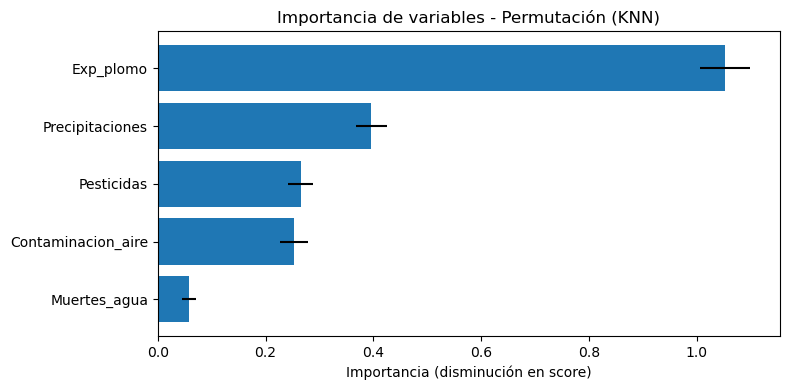

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor

# 2. Definir variables
variables_independientes = ['Contaminacion_aire', 'Muertes_agua', 'Exp_plomo', 'Pesticidas','Precipitaciones']
variable_dependiente = 'Parkinson'

# 3. Entrenar modelo global (sin separar por país)
modelo_global, _ = entrenar_modelo_knn(df, variables_independientes, variable_dependiente,0.2,True)

## MLP Regressor

In [20]:
# Modelo MLP
def entrenar_modelo_mlp(df, variables_independientes, variable_dependiente, test_size=0.2, ranking=False):
    df = df.copy()

    # 1. Separar X e y
    X = df[variables_independientes]
    y = df[variable_dependiente]

    # 2. Escalar variables
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=variables_independientes)

    # 3. Dividir en entrenamiento y test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)

    # 4. Definir y entrenar el modelo MLP
    modelo = MLPRegressor(hidden_layer_sizes=(256, 128), activation='relu', max_iter=5000, alpha=0.01, random_state=42)
    modelo.fit(X_train, y_train)

    # 5. Evaluación
    y_pred = modelo.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")

    # 6. Importancia por permutación
    resultado = permutation_importance(modelo, X_test, y_test, n_repeats=30, random_state=42)

    importancia_perm = pd.DataFrame({
        'Variable': variables_independientes,
        'Importancia Media': resultado.importances_mean,
        'Desviación': resultado.importances_std
    }).sort_values(by='Importancia Media', ascending=False)

    print("\nImportancia de las variables (Permutación - MLP):")
    print(importancia_perm)
    # Guardar en ruta relativa ../Resultados/Archivos_csv/Datos
    ruta_destino = os.path.join("..","Resultados", "Importancia_variables","CSV")
    os.makedirs(ruta_destino, exist_ok=True)
    ruta_csv = os.path.join(ruta_destino, "Ranking_variables_MLP.csv")
    importancia_perm.to_csv(ruta_csv, index=False)
    print(f"\nArchivo de ranking guardado en: {ruta_csv}")

    if ranking:
        # 7. Gráfico de importancia
        plt.figure(figsize=(8, 4))
        plt.barh(importancia_perm['Variable'], importancia_perm['Importancia Media'],
                 xerr=importancia_perm['Desviación'])
        plt.xlabel("Importancia (disminución en score)")
        plt.title("Importancia de variables - Permutación (MLP)")
        plt.tight_layout()
        plt.gca().invert_yaxis()
        plt.show()

    return modelo, scaler,variables_independientes



MAE: 17.45, RMSE: 28.26, R²: 0.88

Importancia de las variables (Permutación - MLP):
             Variable  Importancia Media  Desviación
2           Exp_plomo           0.683206    0.028769
1        Muertes_agua           0.394069    0.041761
4     Precipitaciones           0.269284    0.018546
3          Pesticidas           0.258387    0.020494
0  Contaminacion_aire           0.177976    0.019695

Archivo de ranking guardado en: ..\Resultados\Importancia_variables\CSV\Ranking_variables_MLP.csv


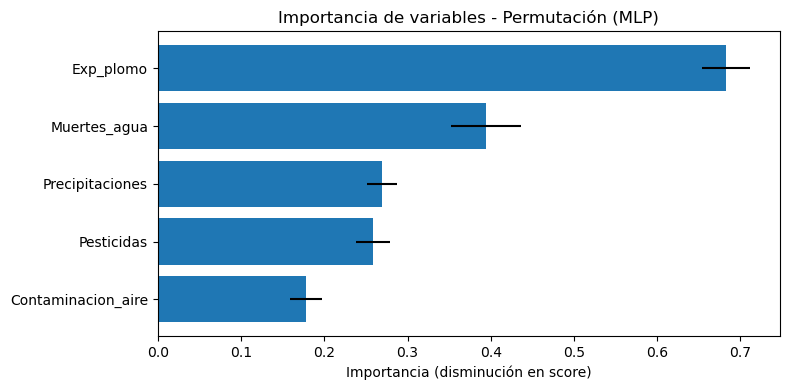

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor

# 2. Definir variables
variables_independientes = ['Contaminacion_aire', 'Muertes_agua', 'Exp_plomo', 'Pesticidas','Precipitaciones']
variable_dependiente = 'Parkinson'

modelo_global, _,_= entrenar_modelo_mlp(df,variables_independientes,variable_dependiente,0.2,True)

# Ranking final

Archivos encontrados:
- ..\Resultados\Importancia_variables\CSV\Ranking_variables_GLM.csv
- ..\Resultados\Importancia_variables\CSV\Ranking_variables_KNN.csv
- ..\Resultados\Importancia_variables\CSV\Ranking_variables_MLP.csv
- ..\Resultados\Importancia_variables\CSV\Ranking_variables_RF.csv
- ..\Resultados\Importancia_variables\CSV\Ranking_variables_SVR.csv
- ..\Resultados\Importancia_variables\CSV\Ranking_variables_XG.csv

🏆 Ranking global promedio de variables:


,Variable,Ranking_Promedio,Ranking_Ranking_variables_GLM,Ranking_Ranking_variables_KNN,Ranking_Ranking_variables_MLP,Ranking_Ranking_variables_RF,Ranking_Ranking_variables_SVR,Ranking_Ranking_variables_XG
0,Exp_plomo,1.000000,1.0,1.0,1.0,1.0,1.0,1.0
1,Precipitaciones,2.666667,1.0,2.0,3.0,4.0,2.0,4.0
2,Pesticidas,2.833333,1.0,3.0,4.0,3.0,3.0,3.0
3,Muertes_agua,2.833333,1.0,5.0,2.0,2.0,5.0,2.0
4,Contaminacion_aire,4.000000,1.0,4.0,5.0,5.0,4.0,5.0



✅ Archivo de ranking guardado en: ..\Resultados\Importancia_variables\CSV\Ranking_global_promedio.csv


C:\Users\luism\AppData\Local\Temp\ipykernel_25920\2003552890.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


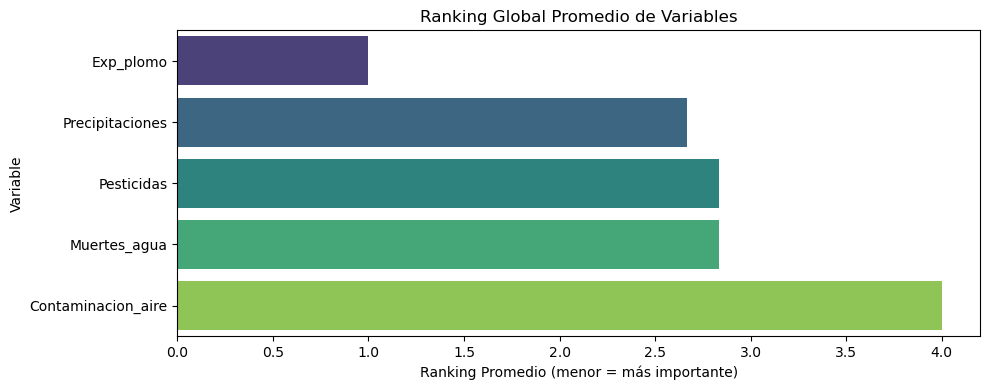

In [27]:
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

# === Paso 1: Definir ruta de entrada ===
ruta_archivos = os.path.join("..","Resultados", "Importancia_variables","CSV")
archivos = glob(os.path.join(ruta_archivos, "Ranking_*.csv"))

# Verificar si hay archivos
if not archivos:
    raise FileNotFoundError(f"No se encontraron archivos 'Ranking_*.csv' en: {ruta_archivos}")

print("Archivos encontrados:")
for archivo in archivos:
    print("-", archivo)

# === Paso 2: Procesar rankings ===
rankings = []

for archivo in archivos:
    df = pd.read_csv(archivo)

    # Detectar y aplicar la métrica correspondiente
    if 'P>|z|' in df.columns:
        df['Ranking'] = df['P>|z|'].rank(method='min', ascending=True)
    elif 'Importancia Media' in df.columns:
        df['Ranking'] = df['Importancia Media'].rank(ascending=False, method='min')
    else:
        raise ValueError(f"No se reconoce la métrica en el archivo: {archivo}")

    # Agrupar por variable por si hay duplicados (aunque no debería)
    df = df.groupby('Variable', as_index=False)['Ranking'].mean()

    # Nombrar columnas según el modelo
    nombre_modelo = os.path.basename(archivo).replace('ranking_', '').replace('.csv', '')
    df_modelo = df[['Variable', 'Ranking']].copy()
    df_modelo.columns = ['Variable', f'Ranking_{nombre_modelo}']

    rankings.append(df_modelo)

# === Paso 3: Combinar rankings ===
ranking_global = rankings[0]
for df_r in rankings[1:]:
    ranking_global = ranking_global.merge(df_r, on='Variable', how='outer')

# Calcular promedio
ranking_cols = [col for col in ranking_global.columns if col.startswith('Ranking_')]
ranking_global['Ranking_Promedio'] = ranking_global[ranking_cols].mean(axis=1)

# Ordenar
ranking_global = ranking_global.sort_values(by='Ranking_Promedio').reset_index(drop=True)

# Mostrar
print("\n🏆 Ranking global promedio de variables:")
display(ranking_global[['Variable', 'Ranking_Promedio'] + ranking_cols])

# === Paso 4: Guardar archivo final ===
ruta_destino = os.path.join("..", "Resultados", "Importancia_variables", "CSV")
os.makedirs(ruta_destino, exist_ok=True)

ruta_csv = os.path.join(ruta_destino, "Ranking_global_promedio.csv")
ranking_global[['Variable', 'Ranking_Promedio'] + ranking_cols].to_csv(ruta_csv, index=False)

print(f"\n✅ Archivo de ranking guardado en: {ruta_csv}")

# === Paso 5: Graficar ===
plt.figure(figsize=(10, max(4, len(ranking_global) * 0.5)))
sns.barplot(
    data=ranking_global,
    y='Variable',
    x='Ranking_Promedio',
    palette='viridis',
    dodge=False,
    order=ranking_global['Variable']
)

plt.xlabel("Ranking Promedio (menor = más importante)")
plt.ylabel("Variable")
plt.title("Ranking Global Promedio de Variables")
plt.tight_layout()
plt.legend([], [], frameon=False)
plt.show()
